## Checking out the data/images

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

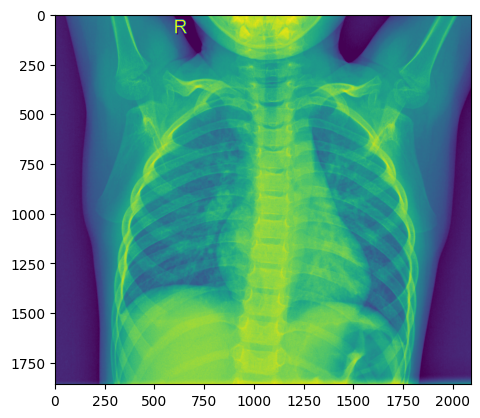

In [6]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [7]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

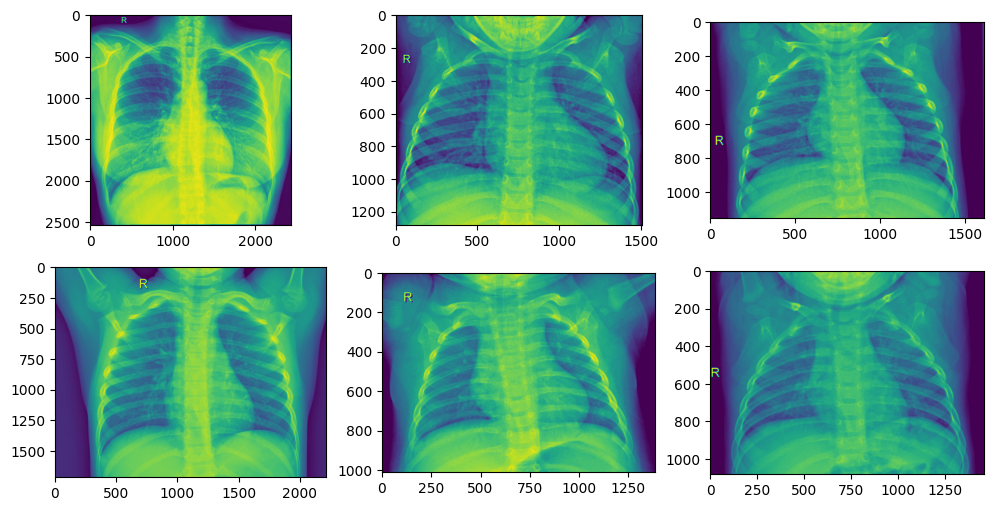

In [8]:
plot_images(training_dir + '/NORMAL')

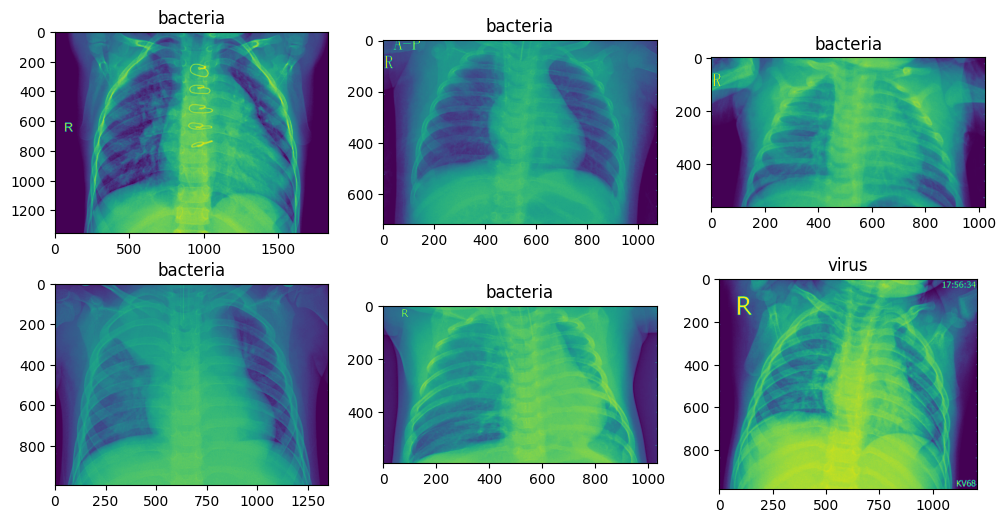

In [9]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

## Train the model

In [10]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

In [11]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False

  model.summary()
  return model

In [13]:
model = get_model()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [14]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

<ipython-input-14-3f45d44a48d8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 190s 1s/step - loss: 0.3513 - accuracy: 0.8861 - val_loss: 0.4731 - val_accuracy: 0.8189
Epoch 2/5
163/163 [==============================] - 185s 1s/step - loss: 0.2001 - accuracy: 0.9195 - val_loss: 0.6444 - val_accuracy: 0.7869
Epoch 3/5
163/163 [==============================] - 189s 1s/step - loss: 0.1865 - accuracy: 0.9287 - val_loss: 0.3753 - val_accuracy: 0.8622
Epoch 4/5
163/163 [==============================] - 181s 1s/step - loss: 0.1808 - accuracy: 0.9293 - val_loss: 0.3262 - val_accuracy: 0.8910
Epoch 5/5
163/163 [==============================] - 184s 1s/step - loss: 0.1683 - accuracy: 0.9348 - val_loss: 0.4052 - val_accuracy: 0.8670


## Evaluate the model

In [15]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

 3/16 [====>.........................] - ETA: 0s - loss: 1.7051 - accuracy: 0.6667

<ipython-input-15-43df76a80ce6>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)


16/16 [==============================] - 1s 41ms/step - loss: 0.8195 - accuracy: 0.7500
Loss: 0.819516658782959
Accuracy: 0.75


In [16]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

1/1 [==============================] - 0s 58ms/step


[array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [3]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

In [4]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

NameError: ignored

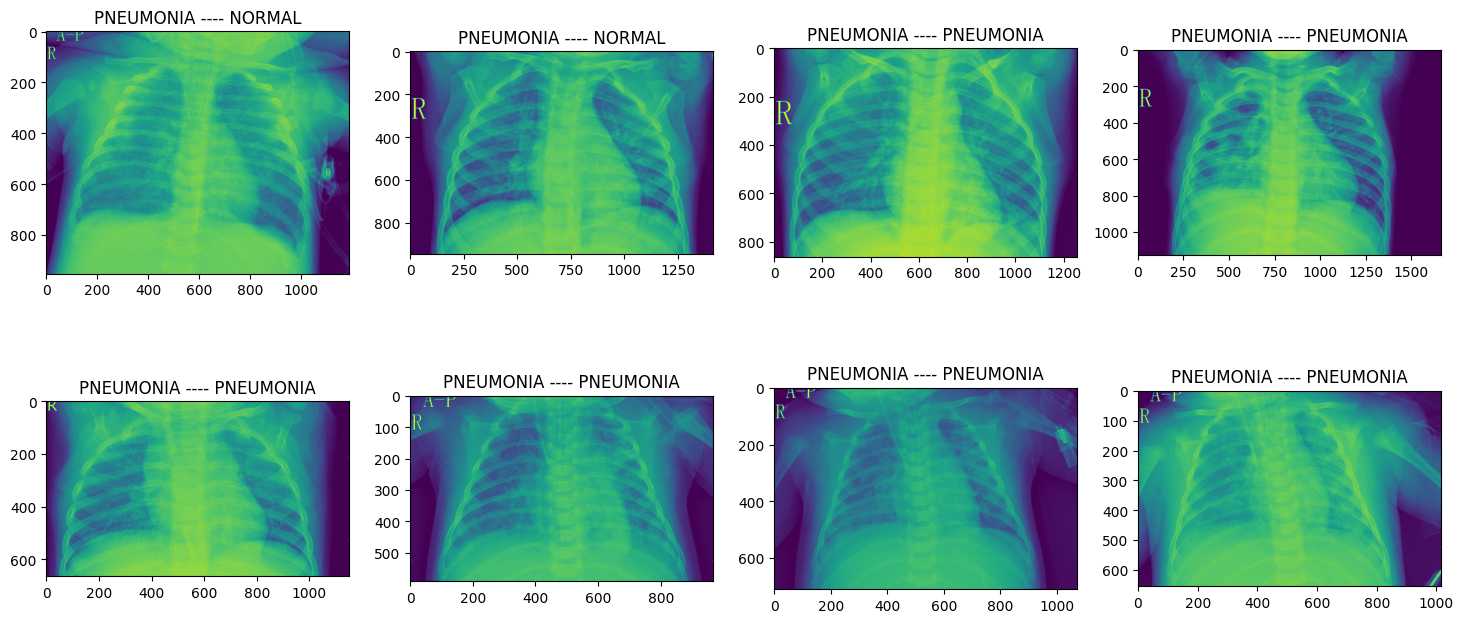

In [19]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

## Model saving and loading

In [20]:
model.save('awesome_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
new_model = keras.models.load_model('awesome_model.h5')